In [19]:
#| code-fold: true
#| code-summary: 'Read data'
#| warning: false
#| output: false

#%pip install scikit-learn 
#%pip install tensorflow
#%pip install plotly
#%pip install statsmodels 
#%pip install IPython 
#%pip install matplotlib 
#%pip install seaborn 
#%pip install --upgrade nbformat
#%pip install plotnine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
#| code-fold: true
#| code-summary: 'Read data'
#| warning: false
#| output: false

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import plotly.express as px 
import statsmodels.api as sm 
from IPython.display import IFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
# Import L1 and L2 regularizers from Python
import tensorflow.keras.regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dropout
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

In [6]:
#| code-fold: true
#| code-summary: 'Read data'
#| warning: false
#| output: false


composite_crude_oil_prices = pd.read_csv("data/composite_crude_oil_prices.csv")

citygate_gas_prices = pd.read_csv("data/citygate_gas_prices.csv")

total_electricity_prices = pd.read_csv("data/total_electricity_prices.csv")

gdp_data = pd.read_csv("data/gdp_data.csv")

cpi_data = pd.read_csv("data/cpi_data.csv")

In [7]:
#| code-fold: true
#| code-summary: 'convert to ts'
#| warning: false
#| output: false


# For Crude Oil
composite_crude_oil_prices['Date'] = pd.to_datetime(composite_crude_oil_prices['Date'])
start_year = min(composite_crude_oil_prices['Date']).year
start_month = min(composite_crude_oil_prices['Date']).month
composite_crude_oil_ts = pd.Series(composite_crude_oil_prices['Value'].values, index=pd.date_range(start=f'{start_year}-{start_month}', periods=len(composite_crude_oil_prices), freq='ME'))
# Log-transform Value
composite_crude_oil_prices['LOG_Value'] = np.log(composite_crude_oil_prices['Value'])
oil_log_ts = pd.Series(composite_crude_oil_prices['LOG_Value'].values, index=pd.date_range(start=f'{start_year}-{start_month}', periods=len(composite_crude_oil_prices), freq='ME'))

# For Natural Gas
citygate_gas_prices['Date'] = pd.to_datetime(citygate_gas_prices['Date'])
start_year_gas = min(citygate_gas_prices['Date']).year
start_month_gas = min(citygate_gas_prices['Date']).month
citygate_gas_ts = pd.Series(citygate_gas_prices['Value'].values, index=pd.date_range(start=f'{start_year_gas}-{start_month_gas}', periods=len(citygate_gas_prices), freq='ME'))
# Log-transform Value
citygate_gas_prices['LOG_Value'] = np.log(citygate_gas_prices['Value'])
gas_log_ts = pd.Series(citygate_gas_prices['LOG_Value'].values, index=pd.date_range(start=f'{start_year_gas}-{start_month_gas}', periods=len(citygate_gas_prices), freq='ME'))

# For Electricity
total_electricity_prices['Date'] = pd.to_datetime(total_electricity_prices['Date'])
start_year_elec = min(total_electricity_prices['Date']).year
start_month_elec = min(total_electricity_prices['Date']).month
total_electricity_ts = pd.Series(total_electricity_prices['Value'].values, index=pd.date_range(start=f'{start_year_elec}-{start_month_elec}', periods=len(total_electricity_prices), freq='ME'))
# Log-transform Value
total_electricity_prices['LOG_Value'] = np.log(total_electricity_prices['Value'])
electricity_log_ts = pd.Series(total_electricity_prices['LOG_Value'].values, index=pd.date_range(start=f'{start_year_elec}-{start_month_elec}', periods=len(total_electricity_prices), freq='ME'))

# For GDP (it's quarterly)
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
start_year_gdp = min(gdp_data['DATE']).year
start_quarter_gdp = min(gdp_data['DATE']).quarter
# Log-transform GDP
gdp_data['LOG_GDP'] = np.log(gdp_data['GDP'])
gdp_log_ts = pd.Series(gdp_data['LOG_GDP'].values, index=pd.date_range(start=f'{start_year_gdp}-Q{start_quarter_gdp}', periods=len(gdp_data), freq='QE'))

# For CPI (it's monthly)
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
start_year_cpi = min(cpi_data['DATE']).year
start_month_cpi = min(cpi_data['DATE']).month
# Log-transform CPI
cpi_data['LOG_CPI'] = np.log(cpi_data['CPIAUCSL'])
cpi_log_ts = pd.Series(cpi_data['LOG_CPI'].values, index=pd.date_range(start=f'{start_year_cpi}-{start_month_cpi}', periods=len(cpi_data), freq='ME'))


# 1. Introduction


Time series forecasting plays a pivotal role in various domains, including economics, finance, and business operations. Accurately predicting future trends based on historical data can provide valuable insights for decision-making and strategic planning. Traditionally, statistical methods such as Autoregressive Integrated Moving Average (ARIMA) models have been widely employed for time series analysis. However, these conventional approaches often struggle to capture intricate patterns, non-linear relationships, and long-term dependencies present in complex time series data.

In recent years, deep learning techniques have emerged as powerful alternatives, offering new avenues for time series forecasting. Neural networks, with their ability to learn from data and uncover intricate patterns, have shown remarkable potential in handling sequential data and capturing temporal dependencies. This exploration focuses on three prominent deep learning architectures: Recurrent Neural Networks (RNNs), Long Short-Term Memory Networks (LSTMs), and Gated Recurrent Units (GRUs), each designed to tackle the unique challenges of time series data.

The objective of this study is to evaluate the performance of these deep learning models in forecasting [specify the time series data or domain, e.g., energy prices, stock market trends, or sales data]. By leveraging their capability to handle complex non-linear relationships and long-term dependencies, we aim to enhance our forecasting accuracy and extend the predictive horizon compared to traditional methods.

Furthermore, this exploration will provide insights into the relative strengths and weaknesses of each neural network architecture, informing future decisions on selecting the most suitable approach for specific time series forecasting tasks. We will thoroughly analyze and compare the accuracy, predictive power, and generalization capabilities of RNNs, LSTMs, and GRUs, offering a comprehensive understanding of their applicability in the realm of time series analysis.

By embracing deep learning techniques, we strive to push the boundaries of time series forecasting, enabling more informed decision-making and strategic planning across various industries and domains. This study will contribute to the growing body of knowledge in the field, advancing our understanding of the potential and limitations of deep learning for time series analysis.



# 2. Data Visualization

To better understand the patterns in our data, we will first visualize it to examine any trends, seasonality, or anomalies. The visualization helps provide insights into how this time series behaves over time.


::: panel-tabset

## Crude Oil


/var/folders/5_/t64jk8752rs72hkv2xkz4g9h0000gn/T/ipykernel_80084/72873405.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


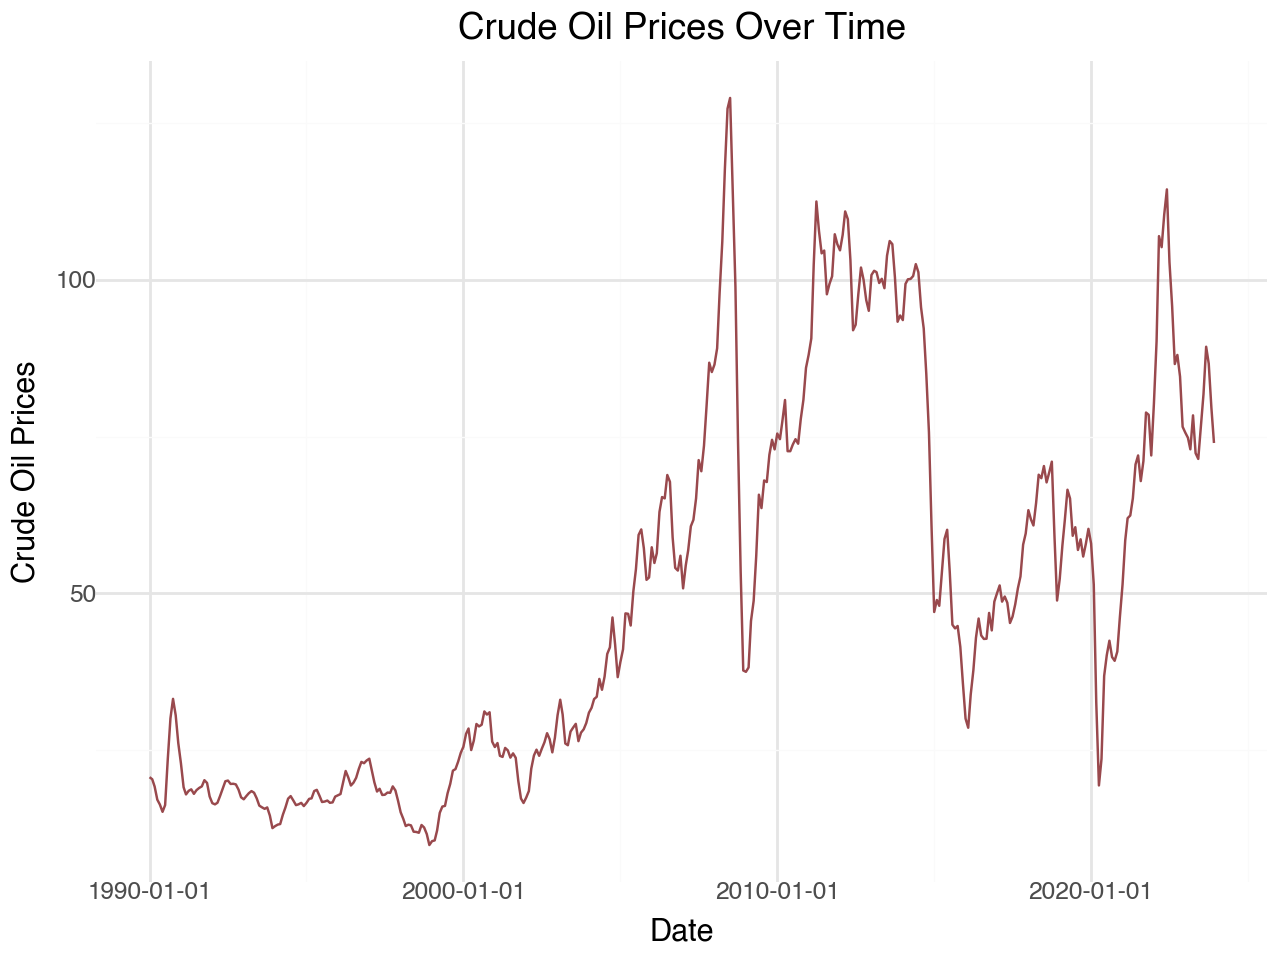

In [8]:
#| code-fold: true
#| code-summary: 'Code'
#| warning: false
#| output: true

# Creating the plot
oil_plot = (
    ggplot(composite_crude_oil_prices, aes(x='Date', y='Value')) +
    geom_line(color='#99494d') +  # Setting the line color
    labs(title='Crude Oil Prices Over Time', x='Date', y='Crude Oil Prices') +
    theme_minimal()  # Using a minimal theme for a clean look
)

# Display the plot
print(oil_plot)

## Natural Gas

In [9]:
#| code-fold: true
#| code-summary: 'Code'
#| warning: false
#| output: true

ng_plot = px.line(citygate_gas_prices, x='Date', y='Value', title='Natural Gas Price Over Time', labels={'Date': 'Date', 'Value': 'Price (USD)'})
ng_plot.update_traces(line_color='#99494d')
ng_plot.update_layout(template='plotly_white', title_x=0.5)

ng_plot.show()

## Electricty

In [10]:
#| code-fold: true
#| code-summary: 'Code'
#| warning: false
#| output: true

#Plotting with ggplot2
electricity_plot = px.line(total_electricity_prices, x='Date', y='Value', title='Average Price of Electricity to Ultimate Customers', labels={'Date': 'Date', 'Value': 'Price (Cents per Kilowatthour)'})
electricity_plot.update_traces(line_color='#99494d')
electricity_plot.update_layout(template='plotly_white', title_x=0.5)
electricity_plot.show()

## GDP

In [11]:
#| code-fold: true
#| code-summary: 'Code'
#| warning: false
#| output: true

#Plotting with ggplot2
gdp_plot = px.line(gdp_data, x='DATE', y='GDP', title='Gross Domestic Product Over Time', labels={'DATE': 'Date', 'GDP': 'GDP (Billion USD)'})
gdp_plot.update_traces(line_color='#99494d')
gdp_plot.update_layout(template='plotly_white', title_x=0.5)
gdp_plot.show()

## CPI

In [12]:
#| code-fold: true
#| code-summary: 'Code'
#| warning: false
#| output: true

#Plotting with ggplot2
cpi_plot = px.line(cpi_data, x='DATE', y='CPIAUCSL', title='Consumer Price Index Over Time', labels={'DATE': 'Date', 'CPIAUCSL': 'CPI'})
cpi_plot.update_traces(line_color='#99494d')
cpi_plot.update_layout(template='plotly_white', title_x=0.5)
cpi_plot.show()

::: 